In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [11]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [28]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [39]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    dataframe["label"] = dataframe["label"] - 1
  
    print(dataframe["label"].unique())
    
    
    curr_num = dataframe.loc[dataframe['label'] == 0]
    
    dataFinal = curr_num.sample(n=90)
    #print(f"{i}:{curr_num_sub.shape}")
    #dataFinal.append(curr_num_sub)
        
        
    for i in range(1, 6):
        
        curr_num = dataframe.loc[dataframe['label'] == i]
        curr_num_sub = curr_num.sample(n=90)
        print(f"{i}:{curr_num_sub.shape}")
        dataFinal = dataFinal.append(curr_num_sub, ignore_index=True)
        
    
    
    print(dataFinal.shape)
    
    dataframe = dataFinal
    labels = dataframe["label"]#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [40]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
1:(90, 55)
2:(90, 55)
3:(90, 55)
4:(90, 55)
5:(90, 55)
(540, 55)
[0. 1. 2. 3. 4. 5.]
(540, 51) (540, 6)


In [41]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    print(f"{i}: {num_i}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION
0: 0.16666666666666666
0: 72
1: 0.16666666666666666
1: 72
2: 0.1712962962962963
2: 74
3: 0.16898148148148148
3: 73
4: 0.1527777777777778
4: 66
5: 0.1736111111111111
5: 75

TEST DISTRIBUTION
0: 0.1111111111111111
1: 0.16666666666666666
2: 0.14814814814814814
3: 0.18518518518518517
4: 0.2037037037037037
5: 0.18518518518518517


In [42]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.40792055 0.40792055 0.41925168 0.41358612 0.37392717 0.42491724]
[2.451457742186962, 2.451457742186962, 2.38520212753326, 2.417876129280291, 2.6743175369312304, 2.3533994324994834]


In [43]:
class_weights = {}
for i in range(6):
    class_weights[i] = weight_balanced[i]

In [44]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [46]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     
 mbda)    

In [47]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [48]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
23/27 [========================>.....] - ETA: 0s - loss: 0.3300 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1840.0000 - fn: 368.0000 - accuracy: 0.8333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5099 - prc: 0.1740
Epoch 1: val_loss improved from inf to 0.31896, saving model to weights.best.onlyfocalloss


2022-05-31 02:15:38.711132: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
27/27 [==============================] - 5s 109ms/step - loss: 0.3293 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2160.0000 - fn: 432.0000 - accuracy: 0.8333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5190 - prc: 0.1818 - val_loss: 0.3190 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 270.0000 - val_fn: 54.0000 - val_accuracy: 0.8333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7419 - val_prc: 0.4413
Epoch 2/200
23/27 [========================>.....] - ETA: 0s - loss: 0.3192 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1840.0000 - fn: 368.0000 - accuracy: 0.8333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6522 - prc: 0.2777
Epoch 2: val_loss improved from 0.31896 to 0.30219, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
27/27 [==============================] - 2s 69ms/step - loss: 0.3183 - tp: 0.0000e+00 - fp: 0.000

27/27 [==============================] - 2s 62ms/step - loss: 0.2220 - tp: 25.0000 - fp: 7.0000 - tn: 2153.0000 - fn: 407.0000 - accuracy: 0.8403 - precision: 0.7812 - recall: 0.0579 - auc: 0.8559 - prc: 0.5589 - val_loss: 0.1731 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 270.0000 - val_fn: 50.0000 - val_accuracy: 0.8457 - val_precision: 1.0000 - val_recall: 0.0741 - val_auc: 0.9207 - val_prc: 0.7765
Epoch 12/200
22/27 [=======================>......] - ETA: 0s - loss: 0.2116 - tp: 26.0000 - fp: 7.0000 - tn: 1753.0000 - fn: 326.0000 - accuracy: 0.8423 - precision: 0.7879 - recall: 0.0739 - auc: 0.8691 - prc: 0.5805
Epoch 12: val_loss improved from 0.17313 to 0.17247, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
27/27 [==============================] - 2s 62ms/step - loss: 0.2106 - tp: 30.0000 - fp: 9.0000 - tn: 2151.0000 - fn: 402.0000 - accuracy: 0.8414 - precision: 0.7692 - recall: 0.0694 - auc: 0.8717 - prc: 0.5

Epoch 22/200
23/27 [========================>.....] - ETA: 0s - loss: 0.1838 - tp: 63.0000 - fp: 12.0000 - tn: 1828.0000 - fn: 305.0000 - accuracy: 0.8564 - precision: 0.8400 - recall: 0.1712 - auc: 0.9013 - prc: 0.6677
Epoch 22: val_loss improved from 0.14978 to 0.14859, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
27/27 [==============================] - 2s 71ms/step - loss: 0.1814 - tp: 69.0000 - fp: 14.0000 - tn: 2146.0000 - fn: 363.0000 - accuracy: 0.8546 - precision: 0.8313 - recall: 0.1597 - auc: 0.9038 - prc: 0.6718 - val_loss: 0.1486 - val_tp: 15.0000 - val_fp: 0.0000e+00 - val_tn: 270.0000 - val_fn: 39.0000 - val_accuracy: 0.8796 - val_precision: 1.0000 - val_recall: 0.2778 - val_auc: 0.9398 - val_prc: 0.8132
Epoch 23/200
23/27 [========================>.....] - ETA: 0s - loss: 0.1799 - tp: 76.0000 - fp: 12.0000 - tn: 1828.0000 - fn: 292.0000 - accuracy: 0.8623 - precision: 0.8636 - recall: 0.2065 - auc: 0.904

23/27 [========================>.....] - ETA: 0s - loss: 0.1507 - tp: 100.0000 - fp: 7.0000 - tn: 1833.0000 - fn: 268.0000 - accuracy: 0.8755 - precision: 0.9346 - recall: 0.2717 - auc: 0.9333 - prc: 0.7755
Epoch 33: val_loss did not improve from 0.13291
27/27 [==============================] - 0s 4ms/step - loss: 0.1510 - tp: 120.0000 - fp: 8.0000 - tn: 2152.0000 - fn: 312.0000 - accuracy: 0.8765 - precision: 0.9375 - recall: 0.2778 - auc: 0.9328 - prc: 0.7723 - val_loss: 0.1362 - val_tp: 19.0000 - val_fp: 1.0000 - val_tn: 269.0000 - val_fn: 35.0000 - val_accuracy: 0.8889 - val_precision: 0.9500 - val_recall: 0.3519 - val_auc: 0.9475 - val_prc: 0.8249
Epoch 34/200
22/27 [=======================>......] - ETA: 0s - loss: 0.1589 - tp: 96.0000 - fp: 9.0000 - tn: 1751.0000 - fn: 256.0000 - accuracy: 0.8745 - precision: 0.9143 - recall: 0.2727 - auc: 0.9266 - prc: 0.7415
Epoch 34: val_loss improved from 0.13291 to 0.13015, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets w

Epoch 45/200
23/27 [========================>.....] - ETA: 0s - loss: 0.1568 - tp: 112.0000 - fp: 14.0000 - tn: 1826.0000 - fn: 256.0000 - accuracy: 0.8777 - precision: 0.8889 - recall: 0.3043 - auc: 0.9252 - prc: 0.7385
Epoch 45: val_loss did not improve from 0.12616
27/27 [==============================] - 0s 4ms/step - loss: 0.1549 - tp: 128.0000 - fp: 17.0000 - tn: 2143.0000 - fn: 304.0000 - accuracy: 0.8762 - precision: 0.8828 - recall: 0.2963 - auc: 0.9278 - prc: 0.7430 - val_loss: 0.1305 - val_tp: 22.0000 - val_fp: 1.0000 - val_tn: 269.0000 - val_fn: 32.0000 - val_accuracy: 0.8981 - val_precision: 0.9565 - val_recall: 0.4074 - val_auc: 0.9513 - val_prc: 0.8337
Epoch 46/200
22/27 [=======================>......] - ETA: 0s - loss: 0.1447 - tp: 110.0000 - fp: 14.0000 - tn: 1746.0000 - fn: 242.0000 - accuracy: 0.8788 - precision: 0.8871 - recall: 0.3125 - auc: 0.9379 - prc: 0.7791
Epoch 46: val_loss did not improve from 0.12616
27/27 [==============================] - 0s 4ms/step - 

Epoch 57/200
22/27 [=======================>......] - ETA: 0s - loss: 0.1415 - tp: 121.0000 - fp: 14.0000 - tn: 1746.0000 - fn: 231.0000 - accuracy: 0.8840 - precision: 0.8963 - recall: 0.3438 - auc: 0.9412 - prc: 0.7907
Epoch 57: val_loss did not improve from 0.12316
27/27 [==============================] - 0s 4ms/step - loss: 0.1436 - tp: 151.0000 - fp: 20.0000 - tn: 2140.0000 - fn: 281.0000 - accuracy: 0.8839 - precision: 0.8830 - recall: 0.3495 - auc: 0.9392 - prc: 0.7812 - val_loss: 0.1233 - val_tp: 24.0000 - val_fp: 1.0000 - val_tn: 269.0000 - val_fn: 30.0000 - val_accuracy: 0.9043 - val_precision: 0.9600 - val_recall: 0.4444 - val_auc: 0.9551 - val_prc: 0.8428
Epoch 58/200
22/27 [=======================>......] - ETA: 0s - loss: 0.1331 - tp: 137.0000 - fp: 12.0000 - tn: 1748.0000 - fn: 215.0000 - accuracy: 0.8925 - precision: 0.9195 - recall: 0.3892 - auc: 0.9465 - prc: 0.8040
Epoch 58: val_loss did not improve from 0.12316
27/27 [==============================] - 0s 4ms/step - 

23/27 [========================>.....] - ETA: 0s - loss: 0.1398 - tp: 143.0000 - fp: 19.0000 - tn: 1821.0000 - fn: 225.0000 - accuracy: 0.8895 - precision: 0.8827 - recall: 0.3886 - auc: 0.9455 - prc: 0.7902
Epoch 68: val_loss did not improve from 0.11901
27/27 [==============================] - 0s 4ms/step - loss: 0.1380 - tp: 164.0000 - fp: 21.0000 - tn: 2139.0000 - fn: 268.0000 - accuracy: 0.8885 - precision: 0.8865 - recall: 0.3796 - auc: 0.9465 - prc: 0.7911 - val_loss: 0.1199 - val_tp: 24.0000 - val_fp: 1.0000 - val_tn: 269.0000 - val_fn: 30.0000 - val_accuracy: 0.9043 - val_precision: 0.9600 - val_recall: 0.4444 - val_auc: 0.9596 - val_prc: 0.8512
Epoch 69/200
23/27 [========================>.....] - ETA: 0s - loss: 0.1316 - tp: 138.0000 - fp: 24.0000 - tn: 1816.0000 - fn: 230.0000 - accuracy: 0.8850 - precision: 0.8519 - recall: 0.3750 - auc: 0.9522 - prc: 0.7979
Epoch 69: val_loss improved from 0.11901 to 0.11849, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Asse

22/27 [=======================>......] - ETA: 0s - loss: 0.1240 - tp: 143.0000 - fp: 11.0000 - tn: 1749.0000 - fn: 209.0000 - accuracy: 0.8958 - precision: 0.9286 - recall: 0.4062 - auc: 0.9560 - prc: 0.8262
Epoch 79: val_loss did not improve from 0.11068
27/27 [==============================] - 0s 4ms/step - loss: 0.1278 - tp: 177.0000 - fp: 17.0000 - tn: 2143.0000 - fn: 255.0000 - accuracy: 0.8951 - precision: 0.9124 - recall: 0.4097 - auc: 0.9528 - prc: 0.8163 - val_loss: 0.1169 - val_tp: 25.0000 - val_fp: 1.0000 - val_tn: 269.0000 - val_fn: 29.0000 - val_accuracy: 0.9074 - val_precision: 0.9615 - val_recall: 0.4630 - val_auc: 0.9629 - val_prc: 0.8614
Epoch 80/200
23/27 [========================>.....] - ETA: 0s - loss: 0.1323 - tp: 153.0000 - fp: 18.0000 - tn: 1822.0000 - fn: 215.0000 - accuracy: 0.8945 - precision: 0.8947 - recall: 0.4158 - auc: 0.9483 - prc: 0.8077
Epoch 80: val_loss did not improve from 0.11068
27/27 [==============================] - 0s 4ms/step - loss: 0.1297 

22/27 [=======================>......] - ETA: 0s - loss: 0.1227 - tp: 155.0000 - fp: 19.0000 - tn: 1741.0000 - fn: 197.0000 - accuracy: 0.8977 - precision: 0.8908 - recall: 0.4403 - auc: 0.9561 - prc: 0.8255
Epoch 91: val_loss did not improve from 0.11068
27/27 [==============================] - 0s 4ms/step - loss: 0.1196 - tp: 190.0000 - fp: 20.0000 - tn: 2140.0000 - fn: 242.0000 - accuracy: 0.8989 - precision: 0.9048 - recall: 0.4398 - auc: 0.9581 - prc: 0.8346 - val_loss: 0.1172 - val_tp: 28.0000 - val_fp: 2.0000 - val_tn: 268.0000 - val_fn: 26.0000 - val_accuracy: 0.9136 - val_precision: 0.9333 - val_recall: 0.5185 - val_auc: 0.9600 - val_prc: 0.8622
Epoch 92/200
22/27 [=======================>......] - ETA: 0s - loss: 0.1306 - tp: 148.0000 - fp: 20.0000 - tn: 1740.0000 - fn: 204.0000 - accuracy: 0.8939 - precision: 0.8810 - recall: 0.4205 - auc: 0.9504 - prc: 0.8069
Epoch 92: val_loss did not improve from 0.11068
27/27 [==============================] - 0s 4ms/step - loss: 0.1265 

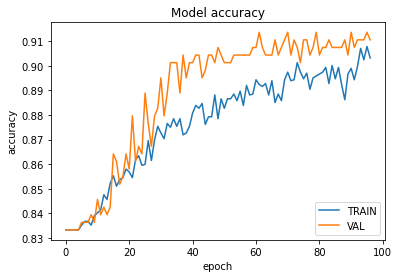

In [54]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

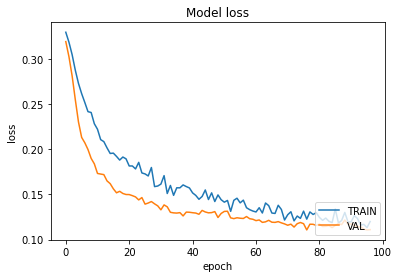

In [55]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [56]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 0.1138 - tp: 21.0000 - fp: 2.0000 - tn: 268.0000 - fn: 33.0000 - accuracy: 0.8920 - precision: 0.9130 - recall: 0.3889 - auc: 0.9639 - prc: 0.8583


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       1.00      0.89      0.94         9
           2       0.55      0.75      0.63         8
           3       0.70      0.70      0.70        10
           4       0.82      0.82      0.82        11
           5       0.91      1.00      0.95        10

    accuracy                           0.80        54
   macro avg       0.83      0.78      0.78        54
weighted avg       0.82      0.80      0.80        54



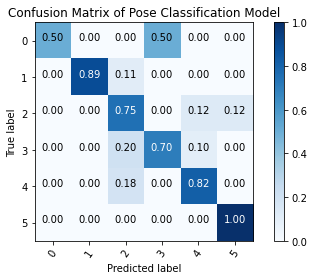

In [57]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [53]:
#Classes 3, 4 Need to be weighted

